# Text Data - Natural Language Processing (NLP)



# ===================================
# Part A.  Introductory Materials
# ===================================


Text data usually consists of a collection of documents (called the corpus) which can represent words, sentences, or even paragraphs of free flowing text. 

The inherent unstructured (no neatly formatted data columns!) and noisy nature of textual data makes it harder for machine learning methods to directly work on raw text data.

# Feature Engineering

Feature engineering dramatically improve performance of machine learning models and wins Kaggle competitions.  This is especially true for text data, which is unstructured, noisy, and complex.  

This section will cover the following types of features for text data

1.  Bag of Words

2.  Bag of N-Grams (uni-gram, bi-gram, tri-gram, etc.)

3.  TF-IDF (term frequency over inverse document frequency)


In [15]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt


A sample "corpus" of documents:  the Document contains short sentences and each text belongs to a category. 

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]

labels = ['weather', 'weather', 'animals', 'animals', 'weather', 'animals']
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,The brown fox is quick and the blue dog is lazy!,animals
4,The sky is very blue and the sky is very beaut...,weather
5,The dog is lazy but the brown fox is quick!,animals


# Text pre-processing


Depending on your downstream task, cleaning and pre-processing text can involve several different components.  Here are a few important components of Natural Language Processing (NLP) pipelines.

1.  Removing tags: unnecessary content like HTML tags

2.  Removing accented characters: other languages such as French, convert ASCII

3. Removing special characters: adds noise to text, use simple regular expressions (regexes)

4.  Stemming and lemmatization: Stemming remove prefixes and suffixes of word stems (i.e. root words), ex. WATCH is the root stem of WATCHES, WATCHING, and WATCHE.  Lemmatization similar but lexicographically correct word (present in the dictionary).

5.  Expanding contractions: helps text standardization, ex. do not to don’t and I would to I’d

6.  Removing stopwords: Words without meaningful significance (ex. a, an, the, and) but high frequency.

Additional pre-processing: tokenization, removing extra whitespaces,  lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.



In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog', 'brown fox quick blue dog lazy',
       'sky blue sky beautiful today', 'dog lazy brown fox quick'],
      dtype='<U30')

# 1.  Bag of Words Model


This is perhaps the most simple vector space representational model for unstructured text. A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute. The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.



In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix


array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]], dtype=int64)

Thus you can see that our documents have been converted into numeric vectors such that each document is represented by one vector (row) in the above feature matrix. The following code will help represent this in a more easy to understand format.



In [6]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)


,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,1,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,1,0
2,0,0,1,1,1,1,1,0,1,0,0
3,0,1,1,1,1,0,1,0,1,0,0
4,1,1,0,0,0,0,0,0,0,2,1
5,0,0,1,1,1,0,1,0,1,0,0


This should make things more clearer! You can clearly see that each column or dimension in the feature vectors represents a word from the corpus and each row represents one of our documents. The value in any cell, represents the number of times that word (represented by column) occurs in the specific document (represented by row). Hence if a corpus of documents consists of N unique words across all the documents, we would have an N-dimensional vector for each of the documents.



This should make things more clearer! You can clearly see that each column or dimension in the feature vectors represents a word from the corpus and each row represents one of our documents. The value in any cell, represents the number of times that word (represented by column) occurs in the specific document (represented by row). Hence if a corpus of documents consists of N unique words across all the documents, we would have an N-dimensional vector for each of the documents.



# 2.  Bag of N-Grams Model


A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.



In [7]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)


,beautiful sky,beautiful today,blue beautiful,blue dog,blue sky,brown fox,dog lazy,fox jumps,fox quick,jumps lazy,lazy brown,lazy dog,love blue,quick blue,quick brown,sky beautiful,sky blue
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0
3,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.



# 3.  TF-IDF Model


There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency, which uses a combination of two metrics in
its computation, namely: term frequency (tf) and inverse document frequency (idf). This technique was developed for ranking results for queries in search engines and now it is an indispensable model in the world of information retrieval and NLP.

Mathematically, we can define TF-IDF as tfidf = tf x idf, which can be expanded further to be represented as follows.


Here, tfidf(w, D) is the TF-IDF score for word w in document D. The term tf(w, D) represents the term frequency of the word w in document D, which can be obtained from the Bag of Words model. The term idf(w, D) is the inverse document frequency for the term w, which can be computed as the log transform of the total number of documents in the corpus C divided by the document frequency of the word w, which is basically the frequency of documents in the corpus where the word w occurs. There are multiple variants of this model but they all end up giving quite similar results. Let’s apply this on our corpus now!



In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)


,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,0.60,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00
1,0.46,0.39,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.46,0.00
2,0.00,0.00,0.38,0.38,0.38,0.54,0.38,0.00,0.38,0.00,0.00
3,0.00,0.36,0.42,0.42,0.42,0.00,0.42,0.00,0.42,0.00,0.00
4,0.36,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.52
5,0.00,0.00,0.45,0.45,0.45,0.00,0.45,0.00,0.45,0.00,0.00


The TF-IDF based feature vectors for each of our text documents show scaled and normalized values as compared to the raw Bag of Words model values. Interested readers who might want to dive into further details of how the internals of this model work can refer to page 181 of Text Analytics with Python (Springer\Apress; Dipanjan Sarkar, 2016).



# ===================================
# Part B.  Intermediate Materials
# ===================================


There is still time left?  Let's cover some more advanced clustering techniques:

1.  Document Clustering with Similarity Features
2.  Topic Models
3.  Document Similarity


# 1.  Document Similarity


Document similarity is the process of using a distance or similarity based metric that can be used to identify how similar a text document is with any other document(s) based on features extracted from the documents like bag of words or tf-idf.
Thus you can see that we can build on top of the tf-idf based features we engineered in the previous section and use them to generate new features which can be useful in domains like search engines, document clustering and information retrieval by leveraging these similarity based features.

Pairwise document similarity in a corpus involves computing document similarity for each pair of documents in a corpus. Thus if you have C documents in a corpus, you would end up with a C x C matrix such that each row and column represents the similarity score for a pair of documents, which represent the indices at the row and column, respectively. There are several similarity and distance metrics that are used to compute document similarity. These include cosine distance/similarity, euclidean distance, manhattan distance, BM25 similarity, jaccard distance and so on. In our analysis, we will be using perhaps the most popular and widely used similarity metric,
cosine similarity and compare pairwise document similarity based on their TF-IDF feature vectors.




In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df


,0,1,2,3,4,5
0,1.000000,0.753128,0.000000,0.185447,0.807539,0.000000
1,0.753128,1.000000,0.000000,0.139665,0.608181,0.000000
2,0.000000,0.000000,1.000000,0.784362,0.000000,0.839987
3,0.185447,0.139665,0.784362,1.000000,0.109653,0.933779
4,0.807539,0.608181,0.000000,0.109653,1.000000,0.000000
5,0.000000,0.000000,0.839987,0.933779,0.000000,1.000000


Cosine similarity basically gives us a metric representing the cosine of the angle between the feature vector representations of two text documents. Lower the angle between the documents, the closer and more similar they are as depicted in the following figure.


Cosine similarity depictions for text document feature vectors
Looking closely at the similarity matrix clearly tells us that documents (0, 1 and 6), (2, 5 and 7) are very similar to one another and documents 3 and 4 are slightly similar to each other but the magnitude is not very strong, however still stronger than the other documents. This must indicate these similar documents have some similar features. This is a perfect example of grouping or clustering that can be solved by unsupervised learning especially when you are dealing with huge corpora of millions of text documents.



# 2. Document Clustering with Similarity Features


Clustering leverages unsupervised learning to group data points (documents in this scenario) into groups or clusters. We will be leveraging an unsupervised hierarchical clustering algorithm here to try and group similar documents from our toy corpus together by leveraging the document similarity features we generated earlier. There are two types of hierarchical clustering algorithms namely, agglomerative and divisive methods. We will be using a agglomerative clustering algorithm, which is hierarchical clustering using a bottom up approach i.e. each observation or document starts in its own cluster and clusters are successively merged together using a distance metric which measures distances between data points and a linkage merge criterion. A sample depiction is shown in the following figure.


The selection of the linkage criterion governs the merge strategy. Some examples of linkage criteria are Ward, Complete linkage, Average linkage and so on. This criterion is very useful for choosing the pair of clusters (individual documents at the lowest step and clusters in higher steps) to merge at each step is based on the optimal value of an objective function. We choose the Ward’s minimum variance method as our linkage criterion to minimize total within-cluster variance. Hence, at each step, we find the pair of clusters that leads to minimum increase in total within-cluster variance after merging. Since we already have our similarity features, let’s build out the linkage matrix on our sample documents.




In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')


,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,2,5,0.271171,2
1,0,4,0.317548,2
2,3,6,0.373037,3
3,1,7,0.531801,3
4,8,9,3.44916,6


If you closely look at the linkage matrix, you can see that each step (row) of the linkage matrix tells us which data points (or clusters) were merged together. If you have n data points, the linkage matrix, Z will be having a shape of (n — 1) x 4 where Z[i] will tell us which clusters were merged at step i. Each row has four elements, the first two elements are either data point identifiers or cluster labels (in the later parts of the matrix once
multiple data points are merged), the third element is the cluster distance between the first two elements (either data points or clusters), and the last element is the total number of elements\data points in the cluster once the merge is complete. We recommend you refer to the scipy documentation, which explains this in detail.

Let’s now visualize this matrix as a dendrogram to understand the elements better!



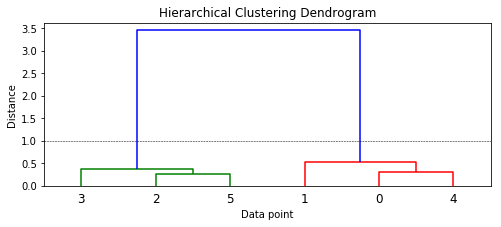

In [17]:

plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)


# Topic Models
We can also use some summarization techniques to extract topic or concept based features from text documents. The idea of topic models revolves around the process of extracting key themes or concepts from a corpus of documents which are represented as topics. Each topic can be represented as a bag or collection of words/terms from the document corpus. Together, these terms signify a specific topic, theme or a concept and each topic can be easily distinguished from other topics by virtue of the semantic meaning conveyed by these terms. However often you do end up with overlapping topics based on the data. These concepts can range from simple facts and statements to opinions and outlook. Topic models are extremely useful in summarizing large corpus of text documents to extract and depict key concepts. They are also useful in extracting features from text data that capture latent patterns in the data.

There are various techniques for topic modeling and most of them involve some form of matrix decomposition. Some techniques like Latent Semantic Indexing (LSI) use matrix decomposition operations, more specifically Singular Valued Decomposition. We will be using another technique is Latent Dirichlet Allocation (LDA), which uses a generative probabilistic model where each document consists of a combination of several topics and each term or word can be assigned to a specific topic. This is similar to pLSI based model (probabilistic LSI). Each latent topic contains a Dirichlet prior over them in the case of LDA.

The math behind in this technique is pretty involved, so I will try to summarize it without boring you with a lot of details. I recommend readers to go through this excellent talk by Christine Doig.

The black box in the above figure represents the core algorithm that makes use of the previously mentioned parameters to extract K topics from M documents. The following steps give a simplistic explanation of what happens in the algorithm behind the scenes.

Once this runs for several iterations, we should have topic mixtures for each document and then generate the constituents of each topic from the terms that point to that topic. Frameworks like gensim or scikit-learn enable us to leverage the LDA model for generating topics.

For the purpose of feature engineering which is the intent of this article, you need to remember that when LDA is applied on a document-term matrix (TF-IDF or Bag of Words feature matrix), it gets decomposed into two main components.

A document-topic matrix, which would be the feature matrix we
are looking for.
A topic-term matrix, which helps us in looking at potential topics in the corpus.
Let’s leverage scikit-learn to get the document-topic matrix as follows.





In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features


c:\users\mglewis\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,T1,T2,T3
0,0.831570,0.084281,0.084149
1,0.864945,0.067312,0.067743
2,0.047801,0.903651,0.048548
3,0.055404,0.896033,0.048563
4,0.887660,0.055993,0.056347
5,0.055710,0.887959,0.056331


You can clearly see which documents contribute the most to which of the three topics in the above output. You can view the topics and their main constituents as follows.



In [23]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()


[('sky', 4.330354268539671), ('blue', 3.3755375835723727), ('beautiful', 3.3301184041393532), ('today', 1.3307001091581214), ('love', 1.329974958258021)]

[('brown', 3.3302369156308287), ('dog', 3.3302369156308287), ('fox', 3.3302369156308287), ('lazy', 3.3302369156308287), ('quick', 3.3302369156308287), ('jumps', 1.330279231916799), ('blue', 1.285679256293642)]

[]



# Document Clustering with Topic Model Features
We used our Bag of Words model based features to build out topic model based features using LDA. We can now actually leverage the document term matrix we obtained and use an unsupervised clustering algorithm to try and group our documents similar to what we did earlier with our similarity features.

We will use a very popular partition based clustering method this time, K-means clustering to cluster or group these documents based on their topic model feature representations. In K-means clustering, we have an input parameter k, which specifies the number of clusters it will output using the document features. This clustering method is a centroid based clustering method, where it tries to cluster these documents into clusters of equal variance. It tries to create these clusters by minimizing the within-cluster sum of squares measure, also known as inertia. There are multiple ways to select the optimal value of k like using the Sum of Squared Errors metric, Silhouette Coefficients and the Elbow method.



In [24]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)


,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,1
3,The brown fox is quick and the blue dog is lazy!,animals,1
4,The sky is very blue and the sky is very beaut...,weather,0
5,The dog is lazy but the brown fox is quick!,animals,1


# ===================================
# Part C.  Advanced Materials
# ===================================


Done and have more time?  Help your classmates with completing their exercise or try the next tutorial on word embeddings as features.

https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

# Shortcomings of traditional models:

Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document. This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

# The need for word embeddings:

While this does make some sense, why should we be motivated enough to learn and build these word embeddings? With regard to speech or image recognition systems, all the information is already present in the form of rich dense feature vectors embedded in high-dimensional datasets like audio spectrograms and image pixel intensities. However when it comes to raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words. This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality.

To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of Vector Space Models (VSMs) in such a way that we can embed word vectors in this continuous vector space based on semantic and contextual similarity. In fact the distributional hypothesis in the field of distributional semantics tells us that words which occur and are used in the same context, are semantically similar to one another and have similar meanings. In simple terms, ‘a word is characterized by the company it keeps’. One of the famous papers talking about these semantic word vectors and various types in detail is ‘Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors’ by Baroni et al. We won’t go into extensive depth but in short, there are two main types of methods for contextual word vectors. Count-based methods like Latent Semantic Analysis (LSA) which can be used to compute some statistical measures of how often words occur with their neighboring words in a corpus and then building out dense word vectors for each word from these measures. Predictive methods like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings. We will be focusing on these predictive methods in this article.


